In [32]:
import numpy as np
import pandas as pd
import string
import os
from collections import Counter, defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
def accuracy_score(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

In [3]:
def tokenizer(text):
    table = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    return text.translate(table).lower().split()

In [4]:
class LogRegressor():
    def __init__(self, classes): 
        self.__version__ = 'v0.1'
        self._classes = classes
        self._vocab = {}
        self._w = dict([(c, defaultdict(int)) for c in classes])
        self._b = dict([(c, 0) for c in classes])
        self._word_stats = defaultdict(int)
  
    def softmax(self, x):
        z = x - max(x)
        numerator = np.exp(z)
        denominator = np.sum(numerator)
        softmax = numerator/denominator
        return softmax
    
    def update_vocab(self, words_list):
        for word in words_list:
            self._word_stats[word] += 1
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        words_list = sample['content']
        target = sample['target']
        target_idx = np.where(self._classes == target)[0][0]
        sample_loss = 0
        z = []
        
        for class_ in self._classes:
            z_i = self._b[class_]
            for word in words_list:
                z_i += self._w[class_][self._vocab[word]] 
            
            z.append(z_i)
        
        z = np.array(z)

        probs = self.softmax(z)

        sample_loss += -np.log(np.clip(probs[target_idx], self.tolerance, 1 - self.tolerance))         
        
        for i, class_ in enumerate(self._classes):
            y = int(class_ == target)
            dLdw =  y - probs[i]
            delta = self.learning_rate * dLdw
            
            for word in words_list:
                self._w[class_][self._vocab[word]] -= -delta
                
            self._b[class_] -= -delta
            

        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        
        return pd.Series({'loss': sample_loss})
    
    def fit_dataframe(self, df, learning_rate=0.1, tolerance=1e-16):
        
        self.total_len = df.shape[0]
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        
        return self.metrics
    
    def predict(self, texts):
        y = []
        for words_list in texts:
            z = []
            for class_ in self._classes:
                z_i = self._b[class_]
                for word in words_list:
                    if word in self._vocab:
                        z_i += self._w[class_][self._vocab[word]] 

                z.append(z_i)
            probs = self.softmax(np.array(z))
            y.append(self._classes[probs.argmax()])
        return y

In [5]:
train_df = pd.read_csv('data/news_train.txt', sep='\t', header=None, names=['target', 'title', 'content'])
test_df = pd.read_csv('data/news_test.txt', sep='\t', header=None, names=['title', 'content'])

In [6]:
train_df.head()

,target,title,content
0,style,Rolex наградит победителей регаты,Парусная гонка Giraglia Rolex Cup пройдет в Ср...
1,sport,Матс Сундин стал советником тренера сборной Шв...,Шведский хоккеист Матс Сундин назначен советни...
2,media,Брендом года по версии EFFIE впервые стал город,"Гран-при конкурса ""Брэнд года/EFFIE"" получил г..."
3,economics,Цена нефти WTI снизилась после публикации данн...,Цена американской нефти WTI на лондонской бирж...
4,economics,Сбербанк распродаст другим банкирам миллиардны...,"Сбербанк выставил на продажу долги по 21,4 тыс..."


In [7]:
test_df.head()

,title,content
0,В МИД Белоруссии одобрили вынос российского фл...,"Белорусский спортсмен, несший на открытии пара..."
1,Про Хана Соло и Бобу Фетта из «Звездных войн» ...,"Стало известно, кто именно будет центральными ..."
2,В Рунете началась вирусная ICQ-эпидемия,Тысячи пользователей стали жертвой нового ICQ-...
3,Шуховскую башню на Оке признали памятником фед...,Башня конструкции инженера Владимира Шухова в ...
4,Голодец предупредила правительство о последств...,Вице-премьер правительства России Ольга Голоде...


In [8]:
train_df.shape, test_df.shape

((60000, 3), (15000, 2))

In [9]:
train_df['content'] = train_df['content'].apply(tokenizer)
test_df['content'] = test_df['content'].apply(tokenizer)

In [10]:
classes = train_df['target'].unique()
model = LogRegressor(classes)

In [11]:
model.generate_vocab(train_df, 'content')

In [12]:
valid_idx = int(train_df.shape[0] * 0.7)

In [13]:
metrics = model.fit_dataframe(train_df[:valid_idx])

LogRegressor v0.1 | 42000 (100.00%) samples fitted.


In [14]:
metrics.head()

,loss
0,1.110223e-16
1,2.110000e+01
2,2.700000e+01
3,8.441465e+00
4,4.787118e-03


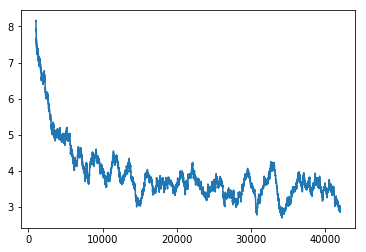

In [15]:
plot = plt.plot(pd.Series(metrics['loss']).rolling(1000).mean())

In [16]:
y_pred = model.predict(train_df['content'][valid_idx:])

In [17]:
y_true = train_df['target'][valid_idx:]

In [18]:
accuracy_score(y_true, y_pred)

0.8096666666666666

**Let's make one more iteration:**

In [19]:
metrics = model.fit_dataframe(train_df[:valid_idx])

LogRegressor v0.1 | 42000 (100.00%) samples fitted.


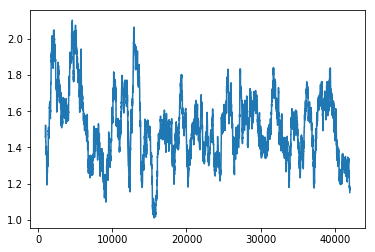

In [20]:
plot = plt.plot(pd.Series(metrics['loss']).rolling(1000).mean())

In [21]:
y_pred = model.predict(train_df['content'][valid_idx:])

In [22]:
y_true = train_df['target'][valid_idx:]

In [23]:
accuracy_score(y_true, y_pred)

0.8524444444444444

**Train all dataframe (we'll make 2 iterations):**

In [24]:
model = LogRegressor(classes)
model.generate_vocab(train_df, 'content')
metrics = model.fit_dataframe(train_df)

LogRegressor v0.1 | 60000 (100.00%) samples fitted.


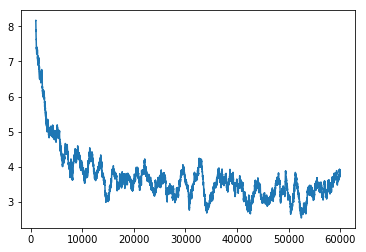

In [25]:
plot = plt.plot(pd.Series(metrics['loss']).rolling(1000).mean())

In [26]:
metrics = model.fit_dataframe(train_df)

LogRegressor v0.1 | 60000 (100.00%) samples fitted.


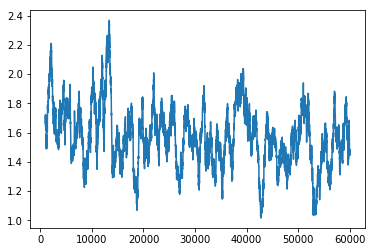

In [27]:
plot = plt.plot(pd.Series(metrics['loss']).rolling(1000).mean())

In [29]:
y_pred = model.predict(test_df['content']) #0.8773

In [33]:
with open(os.path.join('data', 'subm1.txt'), 'w') as f:
    f.write('\n'.join(y_pred))